In [1]:
%matplotlib inline
from quimb.tensor import *

In [2]:
p = MPS_rand_state(n=20, bond_dim=50)
print("Site tags: '{}', site inds: '{}'".format(p.site_tag_id, p.site_ind_id))

Site tags: 'I{}', site inds: 'k{}'


In [3]:
print(p)  # shows the full list of constituent tensors

MatrixProductState([
    Tensor(shape=(50, 2), inds=('_69c3220000000', 'k0'), tags={'I0'}),
    Tensor(shape=(50, 50, 2), inds=('_69c3220000000', '_69c3220000002', 'k1'), tags={'I1'}),
    Tensor(shape=(50, 50, 2), inds=('_69c3220000002', '_69c3220000004', 'k2'), tags={'I2'}),
    Tensor(shape=(50, 50, 2), inds=('_69c3220000004', '_69c3220000006', 'k3'), tags={'I3'}),
    Tensor(shape=(50, 50, 2), inds=('_69c3220000006', '_69c3220000008', 'k4'), tags={'I4'}),
    Tensor(shape=(50, 50, 2), inds=('_69c3220000008', '_69c322000000a', 'k5'), tags={'I5'}),
    Tensor(shape=(50, 50, 2), inds=('_69c322000000a', '_69c322000000c', 'k6'), tags={'I6'}),
    Tensor(shape=(50, 50, 2), inds=('_69c322000000c', '_69c322000000e', 'k7'), tags={'I7'}),
    Tensor(shape=(50, 50, 2), inds=('_69c322000000e', '_69c322000000A', 'k8'), tags={'I8'}),
    Tensor(shape=(50, 50, 2), inds=('_69c322000000A', '_69c322000000C', 'k9'), tags={'I9'}),
    Tensor(shape=(50, 50, 2), inds=('_69c322000000C', '_69c322000000E',

In [4]:
p.show()  # 1D tensor networks also have a ascii ``show`` method

 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 
o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o--o
|  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |


We can then canonicalize the MPS:

In [5]:
p.left_canonize()
p.show()

 2 4 8 16 32 50 50 50 50 50 50 50 50 50 50 50 50 50 50 
>->->->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->--o
| | | |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |


And we can compute the inner product as:

In [6]:
p.H @ p

0.9999999999999999

This relies on them sharing the same physical indices, ``site_ind_id``, 
which the conjugated copy ``p.H`` naturally does.

Like any TN, we can graph the overlap for example, and make use of the 
site tags to color it:

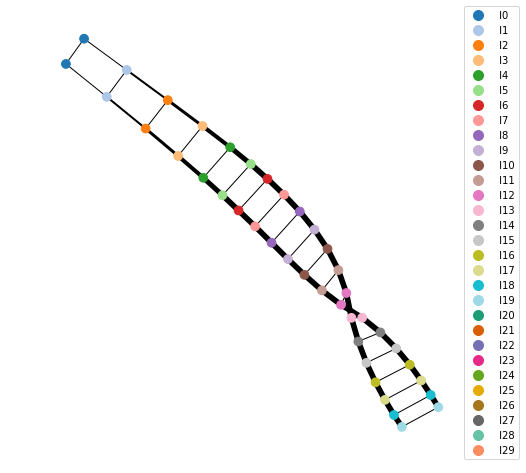

In [7]:
(p.H & p).graph(color=[f'I{i}' for i in range(30)])

I.e. we used the fact that 1D tensor networks are tagged with the structure ``"I{}"`` denoting their sites. See the examples for how to fix the positions of tensors when graphing them.

We can also add MPS, and multiply/divide them by scalars:

In [8]:
p2 = (p + p) / 2
p2.show()

 4 8 16 32 64 100 100 100 100 100 100 100 100 100 100 100 100 100 100 
o-o-o--o--o--o===o===o===o===o===o===o===o===o===o===o===o===o===o===o
| | |  |  |  |   |   |   |   |   |   |   |   |   |   |   |   |   |   |


Which doubles the bond dimension, as expected, but should still be normalized:

In [9]:
p2.H @ p2

0.9999999999999998

Because the MPS is the addition of two identical states, it should also compress right back down:

In [10]:
p2.compress(form=10)
p2.show()

 2 4 8 16 32 50 50 50 50 50 50 50 50 50 32 16 8 4 2 
>->->->-->-->-->-->-->-->--o--<--<--<--<--<--<-<-<-<
| | | |  |  |  |  |  |  |  |  |  |  |  |  |  | | | |


Where we have also set the orthogonality center at the site 10.

When tensor networks are imbued with a ``structure``, they 
can be indexed with integers and slices, which automatically get
converted using ``TN.site_tag_id``:

In [11]:
p2[10]  # get the tensor(s) with tag 'I10'.

Tensor(shape=(50, 50, 2), inds=('_69c322000000C', '_69c322000000E', 'k10'), tags={'I10'})

Note the tensor has matching physical index 'k10'.

This tensor is the orthogonality center:

In [12]:
p2[10].H @ p2[10]  # all indices match -> inner product

0.9999999999999978

Since the MPS is in canonical form, left and right pieces of the overlap should form the identity. The following forms a TN of the inner product, selects the tensors corresponding to the last site (``-1``), contracts them, then gets the underlying data:

In [13]:
((p2.H & p2).select(-1) ^ all).data  # should be close to the identity

array([[1.00000000e+00, 1.69665774e-17],
       [1.69665774e-17, 1.00000000e+00]])

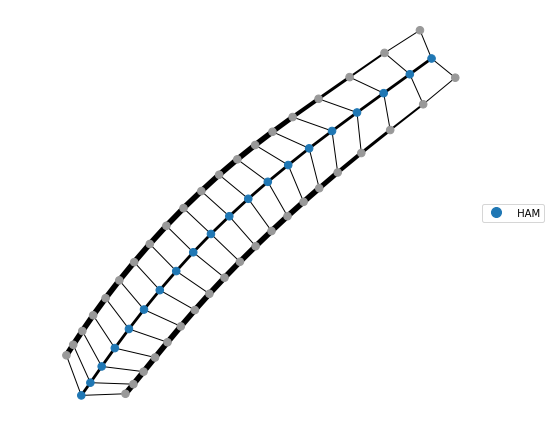

In [14]:
A = MPO_rand_herm(20, bond_dim=7, tags=['HAM'])
pH = p.H

# This modifies the indices of each to form overlap
align_TN_1D(pH, A, p, inplace=True)

(pH & A & p).graph(color='HAM', iterations=1000)

Compute the actual contraction (``...`` means contract everything, but use the structure if possible):

In [15]:
(pH & A & p) ^ ...

2.312217323885412e-07

In [16]:
builder = MPOSpinHam(S=1)
builder.add_term(1/2, '+', '-')
builder.add_term(1/2, '-', '+')
builder.add_term(1, 'Z', 'Z')
H = builder.build(n=100)

In [17]:
dmrg = DMRG2(H, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)

The ``DMRG`` object will automatically detect OBC/PBC. Now we can solve to a certain absolute energy tolerance, showing progress and a schematic of the final state:

In [18]:
dmrg.solve(tol=1e-6, verbosity=1)

SWEEP-1, direction=R, max_bond=10, cutoff:1e-10


100%|███████████████████████████████████████████| 99/99 [00:01<00:00, 50.59it/s]

Energy: -138.73057858421782 ... not converged.
SWEEP-2, direction=R, max_bond=20, cutoff:1e-10



100%|███████████████████████████████████████████| 99/99 [00:01<00:00, 81.66it/s]

Energy: -138.93672651304047 ... not converged.
SWEEP-3, direction=R, max_bond=100, cutoff:1e-10



100%|███████████████████████████████████████████| 99/99 [00:02<00:00, 33.73it/s]

Energy: -138.9400469683024 ... not converged.
SWEEP-4, direction=R, max_bond=100, cutoff:1e-10



100%|███████████████████████████████████████████| 99/99 [00:04<00:00, 23.47it/s]

Energy: -138.94008553353956 ... not converged.
SWEEP-5, direction=R, max_bond=200, cutoff:1e-10



100%|███████████████████████████████████████████| 99/99 [00:08<00:00, 11.18it/s]

Energy: -138.94008605601346 ... converged!


True

In [19]:
dmrg.state.show()

     3 9 27 54 64 73 78 83 86 90 92 93 94 95 95 96 95 94 94 93 93 93 92 92 91 91 91 90 90 90 90 90 90 9    
    >->->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->- ...
    | | |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |     
                                                ...                                                
    0 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 90 9    
... ->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->- ...
     |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |     
                                                ...                                                
    0 90 90 90 90 90 90 90 91 92 93 94 95 96 96 97 97 98 98 97 96 95 93 90 87 83 78 73 64 53 27 9 3 
... ->-->-->-->-->-->-->-->-->-->-->-->-->-->-->-->

In [20]:
from quimb import ham_heis

H_int = ham_heis(n=2, cyclic=False)
H_int

matrix([[ 0.25,  0.  ,  0.  ,  0.  ],
        [ 0.  , -0.25,  0.5 ,  0.  ],
        [ 0.  ,  0.5 , -0.25,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.25]])

In [21]:
psi0 = MPS_neel_state(20)
tebd = TEBD(psi0, H_int)

Now we are ready to evolve, by setting a ``tol``, the required timestep ``dt`` is computed for us:

In [22]:
tebd.update_to(T=3, tol=1e-3)

t=3, max-bond=34: 100%|██████████| 100/100 [00:03<00:00, 20.29%/s]    


After the evolution we can see that entanglement has been generated throughout the chain:

In [23]:
tebd.pt.show()

 2 4 8 16 29 34 33 34 33 34 33 34 33 34 29 16 8 4 2 
>->->->-->-->-->-->-->-->-->-->-->-->-->-->-->->->-o
| | | |  |  |  |  |  |  |  |  |  |  |  |  |  | | | |
